# Recreating SIFT Detector and Object Tracking

I learned about the SIFT detection algorithm for images and how it can be used for object tracking. I'm going to try and reimplement it using OpenCV and numpy. I'm going to be using it on this traffic footage that I got... Don't ask

In [79]:
import cv2
import numpy as np
from IPython import display as disp
from matplotlib import pyplot as plt
import skimage as ski
from scipy import ndimage as ndi
from tqdm.notebook import tqdm
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False
np.set_printoptions(precision=2)

video_file = './data/traffic-video.mp4'

disp.Video(video_file)

## SIFT detector

Let's first get a single still from this video and see what we can produce from it. We'll convert it to grayscale to make things a bit easier for us to write the detector

(720, 1280) uint8


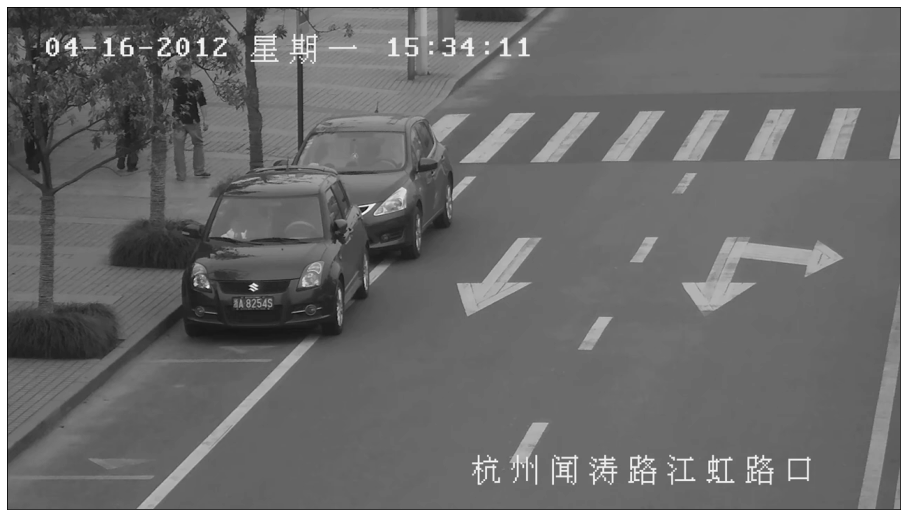

In [42]:
cap = cv2.VideoCapture(video_file)
_,frame = cap.read()
cap.release()

frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
plt.imshow(frame);
print(frame.shape, frame.dtype)

The first thing we need to do is create a stack of gaussians with different sigma ($\sigma$) values. We'll create a logarithmic range of sigmas according to the formula:

$$
\sigma_k = \sigma_0 s^k
$$

We'll set $\sigma_0$ and $s$ depending on what works best

In [66]:
sigmas = 5 * np.logspace(0, 3, base=2, num=100)
x, y = 3, 3
m = sigmas.size // (x*y)
print(sigmas)

[ 5.    5.11  5.21  5.33  5.44  5.55  5.67  5.79  5.91  6.04  6.17  6.3
  6.43  6.57  6.71  6.85  7.    7.15  7.3   7.45  7.61  7.77  7.94  8.11
  8.28  8.45  8.63  8.82  9.    9.19  9.39  9.59  9.79 10.   10.21 10.43
 10.65 10.88 11.11 11.34 11.58 11.83 12.08 12.34 12.6  12.87 13.14 13.42
 13.7  13.99 14.29 14.59 14.9  15.22 15.54 15.87 16.21 16.56 16.91 17.27
 17.63 18.01 18.39 18.78 19.18 19.58 20.   20.42 20.86 21.3  21.75 22.21
 22.69 23.17 23.66 24.16 24.67 25.2  25.73 26.28 26.84 27.41 27.99 28.58
 29.19 29.81 30.44 31.09 31.75 32.42 33.11 33.81 34.53 35.26 36.01 36.78
 37.56 38.35 39.17 40.  ]


Then, for each sigma, we'll do a gaussian filter on the image to create a stack of filtered images. This will simulate viewing the image at different resolutions/scales

Computing Gaussians:   0%|          | 0/100 [00:00<?, ?it/s]

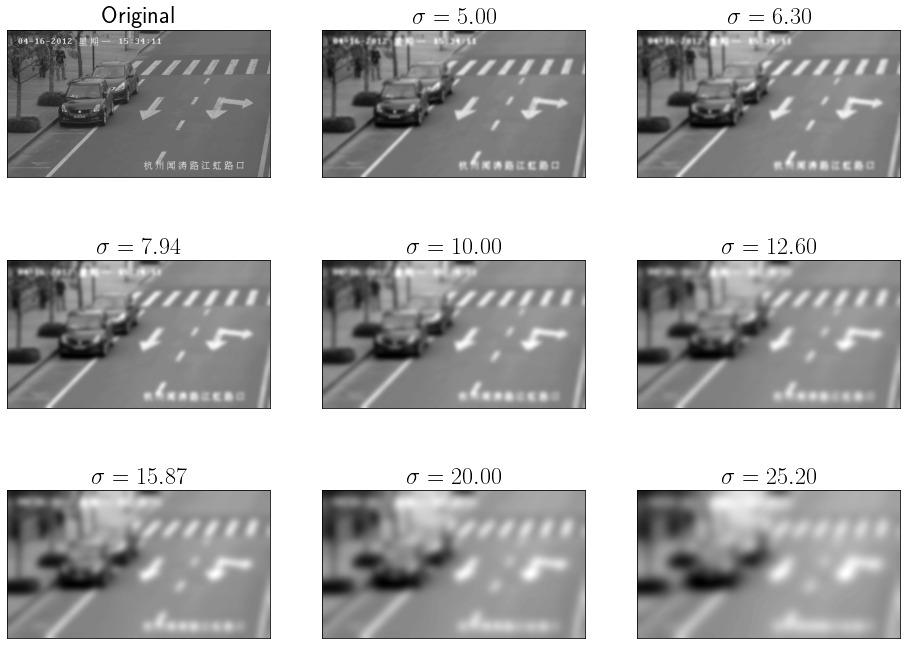

In [67]:
gaussians = np.array([ 
    cv2.GaussianBlur(frame, (0,0), sigma) 
    for sigma in tqdm(sigmas, desc='Computing Gaussians')
])

fig, axs = plt.subplots(x,y)
axs.flat[0].imshow(frame)
axs.flat[0].set_title('Original')
for i in range(x * y - 1):
    axs.flat[i+1].imshow(gaussians[m * i,:,:])
    axs.flat[i+1].set_title(f'$\sigma = {sigmas[m * i]:.2f}$') 
    

Now we'll compute a Difference of Gaussians by subtracting adjacent gaussians in each row.

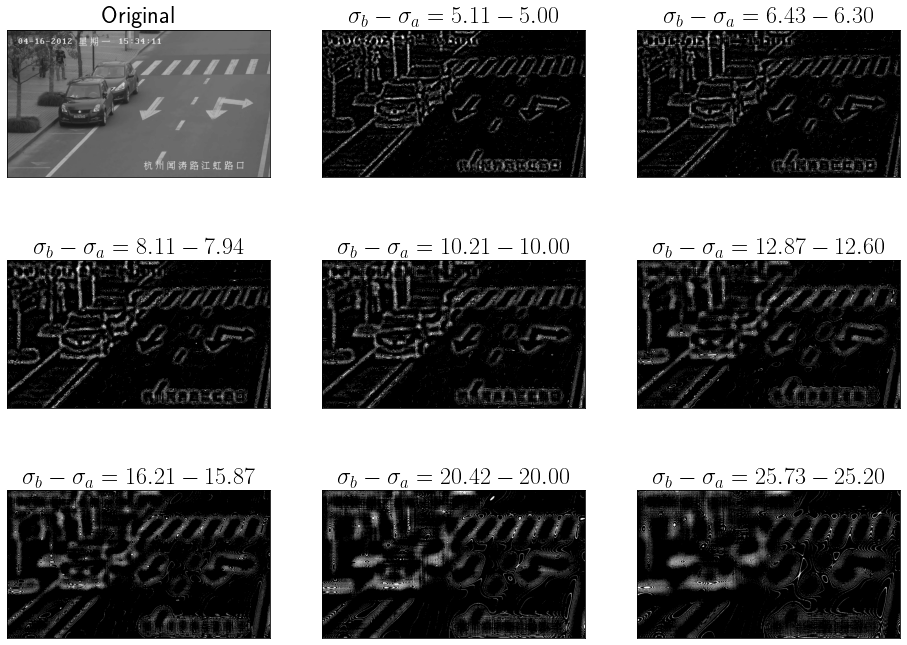

In [70]:
dogs = gaussians[:-1,:,:] - gaussians[1:,:,:]

fig, axs = plt.subplots(x,y)
axs.flat[0].imshow(frame)
axs.flat[0].set_title('Original')
for i in range(x * y - 1):
    axs.flat[i+1].imshow(dogs[m * i,:,:])
    axs.flat[i+1].set_title(f'$\Delta \sigma = {sigmas[m * i + 1]:.2f} - {sigmas[m * i]:.2f} $') 

The (almost) final step is to find all local maximas in this 3D stack of images. I'll just use do this manually

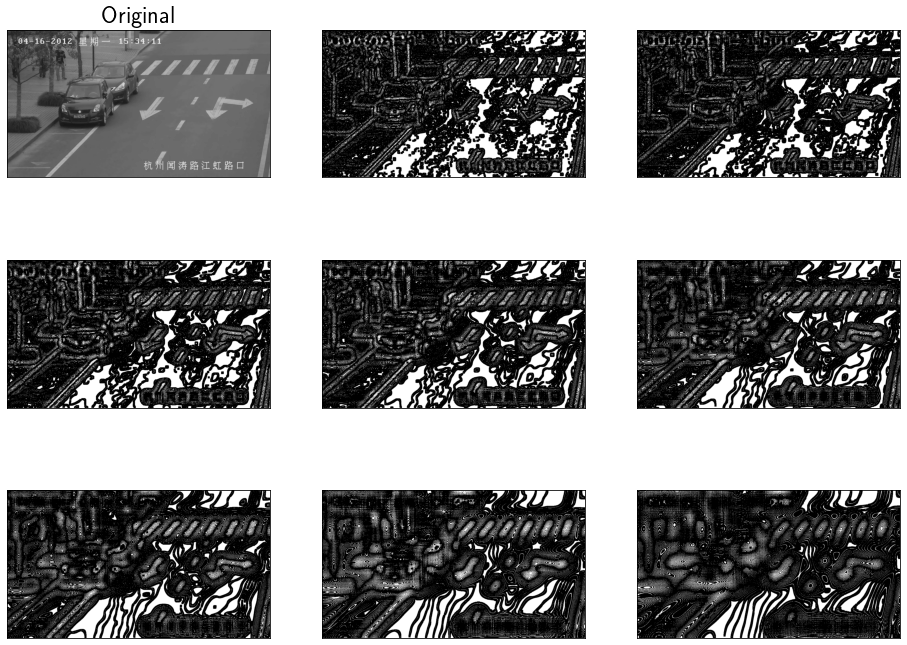

In [89]:
max_filt = ndi.maximum_filter(dogs, size=10, mode='constant') == dogs


fig, axs = plt.subplots(x,y)
axs.flat[0].imshow(frame)
axs.flat[0].set_title('Original')
for i in range(x * y - 1):
    axs.flat[i+1].imshow(max_filt[m * i,:,:])